In [1]:
%matplotlib notebook
import matplotlib.lines as mlines
import matplotlib.pyplot as plt
from lazy_imports import np
from lazy_imports import plt
from lazy_imports import sitk
from lazy_imports import sio
from lazy_imports import torch
from matplotlib.colors import LinearSegmentedColormap

In [2]:
from disp.vis import show_2d, show_2d_tensors
from disp.vis import vis_tensors, vis_path, disp_scalar_to_file
from disp.vis import  disp_vector_to_file, disp_tensor_to_file
from disp.vis import disp_gradG_to_file, disp_gradA_to_file
from disp.vis import gen_and_vis_paths_per_coords, gen_and_vis_paths
from disp.vis import plot_grid_2d

In [3]:
from data.io import readRaw, ReadTensors, ReadScalars, WriteTensorNPArray, WriteScalarNPArray
from data.convert import GetNPArrayFromSITK, GetSITKImageFromNP

In [4]:
import math

In [5]:
import algo.geodesic as geo
import algo.euler as euler

In [6]:
import util.tensors as tensors
import util.diffeo as diffeo

In [7]:
from util.SplitEbinMetric3D import *

In [8]:
def mysavefig(filename):
  plt.gca().set_axis_off()
  plt.subplots_adjust(top = 1, bottom = 0, right = 1, left = 0, 
                hspace = 0, wspace = 0)
  plt.margins(0,0)
  plt.gca().xaxis.set_major_locator(plt.NullLocator())
  plt.gca().yaxis.set_major_locator(plt.NullLocator())
  plt.gcf().savefig(filename, bbox_inches='tight', pad_inches=0, dpi=400, transparent=True)


In [9]:
def plot_diffeo_custom(diffeo, title, step_size=1, show_axis=False, ax=None, filename=''):
    #diffeo = diffeo.detach().numpy()
    #import matplotlib.pyplot as plt
    #
    if ax is None:
      plt.figure(num=None,figsize=(7.25,8.7),  dpi=100, facecolor='w', edgecolor='k')
      plt.tight_layout(pad=0)
      ax = plt.gca()

    if show_axis is False:
      ax.set_axis_off()

    ax.set_aspect('equal')
    for h in range(0, diffeo.shape[1], step_size):
        plt.plot(diffeo[1, h, :], diffeo[0, h, :], 'k', linewidth=0.5)
#         plt.plot(diffeo[0, h, :], diffeo[1, h, :], 'k', linewidth=0.5)
    for w in range(0, diffeo.shape[2], step_size):
        plt.plot(diffeo[1, :, w], diffeo[0, :, w], 'k', linewidth=0.5)
#         plt.plot(diffeo[0, :, w], diffeo[1, :, w], 'k', linewidth=0.5)
       
    if(title):
      plt.title(title)
    if filename:
      plt.savefig(filename, bbox_inches='tight')
    plt.show()
    
def vis_2d(img, title='', ax=None, has_component_data=False, cmap=None, dpi=100, margin=0.05, interpolation=None):
  #pad_img = np.zeros((img.shape[0]+2,img.shape[1]+2))
  #pad_img[1:-1,1:-1] = img
  if type(img) == np.ndarray:
    nda = img
    spacing = [1,1]
  else: 
    nda = GetNPArrayFromSITK(img, has_component_data)
    spacing = img.GetSpacing()
    
  if nda.ndim == 3:
    # fastest dim, either component or x
    c = nda.shape[-1]    
    # the the number of components is 3 or 4 consider it an RGB image
    if not c in (3,4):
      nda = nda[nda.shape[0]//2,:,:]
  
  elif nda.ndim == 4:
    c = nda.shape[-1]
    
    if not c in (3,4):
      raise Runtime("Unable to show 3D-vector Image")
      
    # take a z-slice
    nda = nda[nda.shape[0]//2,:,:,:]

  #ndat = nda.T      
  ysize = nda.shape[0]
  xsize = nda.shape[1]
    
  # Make a figure big enough to accommodate an axis of xpixels by ypixels
  # as well as the ticklabels, etc...
  if xsize > dpi and ysize > dpi:
    figsize = (1 + margin) * ysize / dpi, (1 + margin) * xsize / dpi
  else:
    figsize = (1 + margin) * dpi / ysize, (1 + margin) * dpi / xsize
  #print("fig size: ", figsize)

  #fig = plt.figure(figsize=figsize, dpi=dpi)
  if ax is None:
    fig = plt.figure()
    # Make the axis the right size...
    ax = fig.add_axes([margin, margin, 1 - 2*margin, 1 - 2*margin])
  else:
    pass
    # How to do add_axes equiv for existing axis?  Is it necessary?
    #ax.margins([margin, margin, 1 - 2*margin, 1 - 2*margin])
  
  #extent = (0, xsize*spacing[1], ysize*spacing[0], 0)
  # use following extent when transposing nda array.  previous extent when not transposing
  extent = (-0.5, xsize*spacing[0]+0.5, ysize*spacing[1]-0.5, 0.5)
  
  t = ax.imshow(nda,extent=extent,interpolation=interpolation)
  #t = ax.imshow(nda,interpolation=None)  
  # use following imshow when transposing nda array.  previous imshow when not transposing
  #t = ax.imshow(ndat,extent=extent,interpolation=None, origin="upper")
  
  if nda.ndim == 2:
    if cmap is None:
      t.set_cmap("gray")
    else:
      t.set_cmap(cmap)
  
  if(title):
    plt.title(title)

  return(t)

def grayify_cmap(cmap, numbins=None):
    """Return a grayscale version of the colormap"""
    """From https://jakevdp.github.io/blog/2014/10/16/how-bad-is-your-colormap/ """
    cmap = plt.cm.get_cmap(cmap)
    colors = cmap(np.arange(cmap.N))
    
    # convert RGBA to perceived greyscale luminance
    # cf. http://alienryderflex.com/hsp.html
    RGB_weight = [0.299, 0.587, 0.114]
    luminance = np.sqrt(np.dot(colors[:, :3] ** 2, RGB_weight))
    colors[:, :3] = luminance[:, np.newaxis]
    
    if numbins is None:
        numbins = cmap.N
    
    return LinearSegmentedColormap.from_list(cmap.name + "_grayscale", colors, numbins)  



In [10]:
def plot_geo(geo):
  num_geos = geo.shape[0]    
  tens_fig=plt.figure(figsize=(num_geos*2,4))
  rows=1
  cols=num_geos
  grid = plt.GridSpec(rows, cols,wspace=0)#, top=1, bottom=0, right=1, left=0, wspace=.01, hspace=0)

  axs = []
  for gidx in range(num_geos):
    curax = plt.subplot(grid[0,gidx])
    axs.append(curax)
    geo_upper = np.zeros((geo.shape[1], geo.shape[2], 3))
    geo_upper[:,:,0] = geo[gidx,:,:,0,0]
    geo_upper[:,:,1] = geo[gidx,:,:,0,1]
    geo_upper[:,:,2] = geo[gidx,:,:,1,1]
    vis_tensors(np.transpose(geo_upper,(2,1,0)), '',scale=0.5,opacity=1,ax=curax)

    if not show_axis_labels:
      curax.set_xticks([])
      curax.set_yticks([])
    if gidx == 0:
      curax.set_title('g0')
    elif gidx == ((num_geos-1) / 2):
      curax.set_title('mean')
    elif gidx == (num_geos-1):
      curax.set_title('g1')
        
    curax.set_axis_off()
    #curax.xaxis.set_major_locator(plt.NullLocator())
    #curax.yaxis.set_major_locator(plt.NullLocator())
    curax.set_xlim(-1, geo.shape[2])
    curax.set_ylim(-1, geo.shape[1])
    curax.invert_yaxis()
  return(tens_fig, axs)


In [11]:
indir = '/usr/sci/projects/HCP/Kris/NSFCRCNS/TestData'
fig_dir = '/usr/sci/projects/HCP/Kris/NSFCRCNS/TestResults/MELBAPresentation/figures/'
do_save = True


geo_colors = ['tab:red', 'tab:pink', 'tab:orange', 'tab:blue', 'tab:purple', 'tab:green', 'tab:cyan']
eul_colors = ['k', 'm', 'y', 'tab:olive', 'tab:brown', 'tab:gray', 'maroon']

# from colorbrewer2, sequential 9 values pasted together YlGnBu (reverse order) then YlOrRd
# EXCEPT THESE ARE NOT PRINT FRIENDLY OR PHOTOCOPY SAFE!!!
# But skip the yellows in the middle -- too light
#interp_colors = ['#081d58', '#253494', '#225ea8', '#1d91c0', '#41b6c4', '#7fcdbb', '#c7e9b4', '#edf8b1', '#ffffd9',
#                 '#ffffcc', '#ffeda0', '#fed976', '#feb24c', '#fd8d3c', '#fc4e2a', '#e31a1c', '#bd0026', '#800026']
interp_colors = ['#081d58', '#253494', '#225ea8', '#1d91c0', '#41b6c4', '#7fcdbb', '#c7e9b4',
                 '#fed976', '#feb24c', '#fd8d3c', '#fc4e2a', '#e31a1c', '#bd0026', '#800026']

blue=interp_colors[3]
ltblue=interp_colors[6]
yellow=interp_colors[7]
orange=interp_colors[9]
red=interp_colors[12]

# 3 classes are safest, but fewer options.
# Stitch together some options from sequential 3 values YlGnBu (reverse order), YlOrBr and 
#interp_colors = ['#2c7fb8', '#7fcdbb', '#edf8b1', '#fff7bc', '#fec44f', '#d95f0e']

# Compromise, use 5 class YlGnBu (reverse order) and YlOrBr again leaving out yellow
interp_colors = ['#253494', '#2c7fb8', '#41b6c4', '#a1dab4', '#fed98e', '#fe9929', '#d95f0e', '#993404']
# leave out #ffffcc and #ffffd4

blue=interp_colors[1]
ltblue=interp_colors[2]
yellow=interp_colors[4]
orange=interp_colors[5]
red=interp_colors[7]

# Same as above but with a dark gray added in the front
interp_colors = ['#777777','#253494', '#2c7fb8', '#41b6c4', '#a1dab4', '#fed98e', '#fe9929', '#d95f0e', '#993404']

blue=interp_colors[2]
ltblue=interp_colors[3]
yellow=interp_colors[5]
orange=interp_colors[6]
red=interp_colors[8]

# matches defaults
XSMALL_SIZE = 12
SMALL_SIZE = 15
MEDIUM_SIZE = 18
BIGGER_SIZE = 20
# bigger for papers
XSMALL_SIZE = 12
SMALL_SIZE = 17
MEDIUM_SIZE = 23
BIGGER_SIZE = 25

plt.rcParams["figure.figsize"] = (4, 4) # (w, h)
plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

gray_BuGn = grayify_cmap('BuGn',50)
gray_cubehelix = grayify_cmap('cubehelix',50)

# Plot geodesics for some metrics to illustrate geodesics and mean

<IPython.core.display.Javascript object>


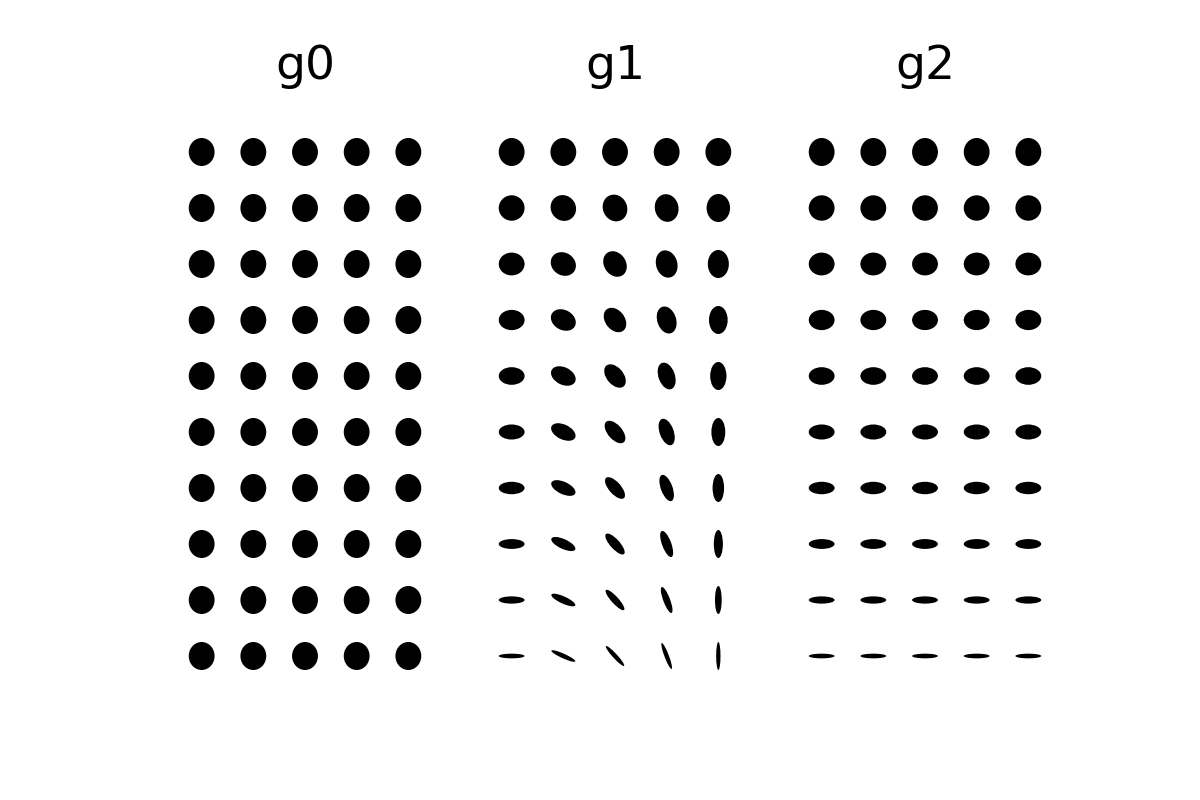

In [12]:
rect_tens = ReadTensors(indir+'/'+'metpy_rect_vary_tens.nhdr')
euc_tens = ReadTensors(indir+'/'+'metpy_rect_iso_tens.nhdr')
show_axis_labels=False

rect_col1_tens = np.zeros_like(rect_tens)
for col in range(rect_tens.shape[1]):
  rect_col1_tens[:,col,:] = rect_tens[:,0,:]

tens_fig=plt.figure(figsize=(6,4))
rows=1
cols=3
grid = plt.GridSpec(rows, cols,wspace=0)#, top=1, bottom=0, right=1, left=0, wspace=.01, hspace=0)

ax00 = plt.subplot(grid[0,0])
vis_tensors(np.transpose(euc_tens,(2,1,0)), '',scale=0.5,opacity=1,ax=ax00)

if not show_axis_labels:
  ax00.set_xticks([])
  ax00.set_yticks([])
ax00.set_title('g0')
ax00.set_axis_off()
#ax00.xaxis.set_major_locator(plt.NullLocator())
#ax00.yaxis.set_major_locator(plt.NullLocator())
ax00.set_xlim(-1, rect_tens.shape[1])
ax00.set_ylim(-1, rect_tens.shape[0])
ax00.invert_yaxis()

ax01 = plt.subplot(grid[0,1])
vis_tensors(np.transpose(rect_tens,(2,1,0)), '', scale=0.5,opacity=1,ax=ax01)

if not show_axis_labels:
  ax01.set_xticks([])
  ax01.set_yticks([])
ax01.set_title('g1')
ax01.set_axis_off()
#ax01.xaxis.set_major_locator(plt.NullLocator())
#ax01.yaxis.set_major_locator(plt.NullLocator())
ax01.set_xlim(-1, euc_tens.shape[1])
ax01.set_ylim(-1, euc_tens.shape[0])
ax01.invert_yaxis()

ax02 = plt.subplot(grid[0,2])
vis_tensors(np.transpose(rect_col1_tens,(2,1,0)), '', scale=0.5,opacity=1,ax=ax02)

if not show_axis_labels:
  ax02.set_xticks([])
  ax02.set_yticks([])
ax02.set_title('g2')
ax02.set_axis_off()
#ax02.xaxis.set_major_locator(plt.NullLocator())
#ax02.yaxis.set_major_locator(plt.NullLocator())
ax02.set_xlim(-1, euc_tens.shape[1])
ax02.set_ylim(-1, euc_tens.shape[0])
ax02.invert_yaxis()
plt.show()

In [13]:
rect_tens_full = np.zeros((rect_tens.shape[0],rect_tens.shape[1],2,2))
euc_tens_full = np.zeros((euc_tens.shape[0],euc_tens.shape[1],2,2))
rect_col1_full = np.zeros((rect_col1_tens.shape[0],rect_col1_tens.shape[1],2,2))
rect_tens_full[:,:,0,0] = rect_tens[:,:,0]
rect_tens_full[:,:,0,1] = rect_tens[:,:,1]
rect_tens_full[:,:,1,0] = rect_tens[:,:,1]
rect_tens_full[:,:,1,1] = rect_tens[:,:,2]
euc_tens_full[:,:,0,0] = euc_tens[:,:,0]
euc_tens_full[:,:,0,1] = euc_tens[:,:,1]
euc_tens_full[:,:,1,0] = euc_tens[:,:,1]
euc_tens_full[:,:,1,1] = euc_tens[:,:,2]
rect_col1_full[:,:,0,0] = rect_col1_tens[:,:,0]
rect_col1_full[:,:,0,1] = rect_col1_tens[:,:,1]
rect_col1_full[:,:,1,0] = rect_col1_tens[:,:,1]
rect_col1_full[:,:,1,1] = rect_col1_tens[:,:,2]

rect_euc_dist = Squared_distance_Ebin_field(torch.from_numpy(euc_tens_full), torch.from_numpy(rect_tens_full), 
                                            1./2, torch.from_numpy(np.ones((rect_tens.shape[0],rect_tens.shape[1])))).detach().numpy()
rect_col1_dist = Squared_distance_Ebin_field(torch.from_numpy(rect_col1_full), torch.from_numpy(rect_tens_full), 
                                            1./2, torch.from_numpy(np.ones((rect_tens.shape[0],rect_tens.shape[1])))).detach().numpy()

rect_euc_mean = get_karcher_mean(torch.stack(tuple([torch.from_numpy(euc_tens_full),torch.from_numpy(rect_tens_full)])),1.0/2.0)
rect_col1_mean = get_karcher_mean(torch.stack(tuple([torch.from_numpy(rect_col1_full),torch.from_numpy(rect_tens_full)])),1.0/2.0)

rect_euc_mean_upper = np.zeros_like(rect_tens)
rect_euc_mean_upper[:,:,0] = rect_euc_mean[:,:,0,0]
rect_euc_mean_upper[:,:,1] = rect_euc_mean[:,:,0,1]
rect_euc_mean_upper[:,:,2] = rect_euc_mean[:,:,1,1]
rect_col1_mean_upper = np.zeros_like(rect_tens)
rect_col1_mean_upper[:,:,0] = rect_col1_mean[:,:,0,0]
rect_col1_mean_upper[:,:,1] = rect_col1_mean[:,:,0,1]
rect_col1_mean_upper[:,:,2] = rect_col1_mean[:,:,1,1]

torch.symeig is deprecated in favor of torch.linalg.eigh and will be removed in a future PyTorch release.
The default behavior has changed from using the upper triangular portion of the matrix by default to using the lower triangular portion.
L, _ = torch.symeig(A, upper=upper)
should be replaced with
L = torch.linalg.eigvalsh(A, UPLO='U' if upper else 'L')
and
L, V = torch.symeig(A, eigenvectors=True)
should be replaced with
L, V = torch.linalg.eigh(A, UPLO='U' if upper else 'L') (Triggered internally at  ../aten/src/ATen/native/BatchLinearAlgebra.cpp:2500.)


<IPython.core.display.Javascript object>


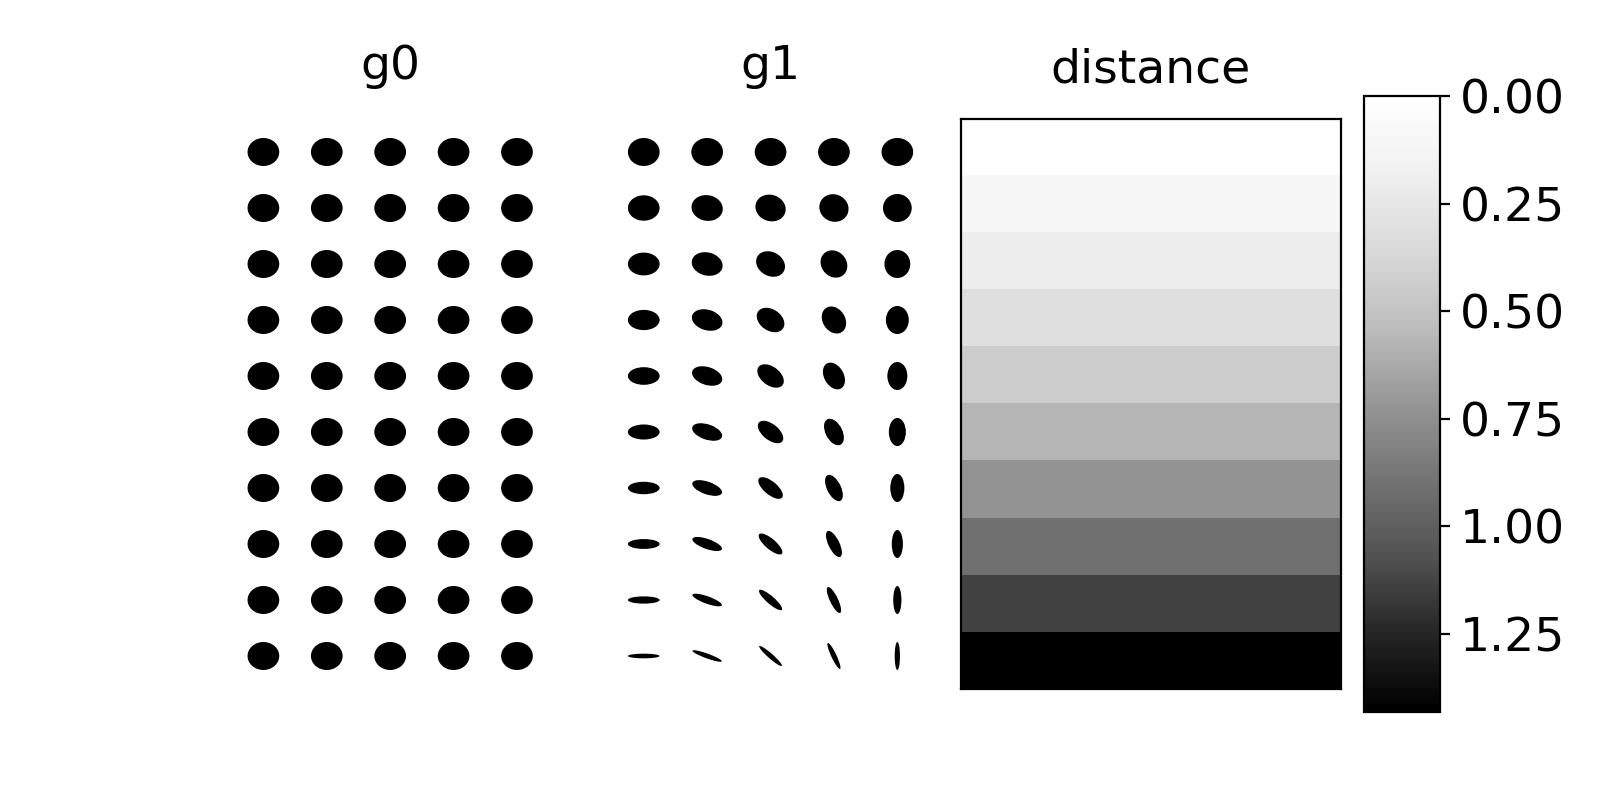

In [14]:
tens_fig=plt.figure(figsize=(8,4))
rows=1
cols=5 # 4th column is for spacing
grid = plt.GridSpec(rows, cols,wspace=0, width_ratios=(5,5,5,0.3,1))#, top=1, bottom=0, right=1, left=0, wspace=.01, hspace=0)


ax00 = plt.subplot(grid[0,0])
vis_tensors(np.transpose(euc_tens,(2,1,0)), '',scale=0.5,opacity=1,ax=ax00)

if not show_axis_labels:
  ax00.set_xticks([])
  ax00.set_yticks([])
ax00.set_title('g0')
ax00.set_axis_off()
#ax00.xaxis.set_major_locator(plt.NullLocator())
#ax00.yaxis.set_major_locator(plt.NullLocator())
ax00.set_xlim(-1, rect_tens.shape[1])
ax00.set_ylim(-1, rect_tens.shape[0])
ax00.invert_yaxis()

ax01 = plt.subplot(grid[0,1])
vis_tensors(np.transpose(rect_tens,(2,1,0)), '', scale=0.5,opacity=1,ax=ax01)

if not show_axis_labels:
  ax01.set_xticks([])
  ax01.set_yticks([])
ax01.set_title('g1')
ax01.set_axis_off()
#ax01.xaxis.set_major_locator(plt.NullLocator())
#ax01.yaxis.set_major_locator(plt.NullLocator())
ax01.set_xlim(-1, euc_tens.shape[1])
ax01.set_ylim(-1, euc_tens.shape[0])
ax01.invert_yaxis()

ax02 = plt.subplot(grid[0,2])
#factor = 255/np.max(rect_euc_dist)

imobj = vis_2d(np.sqrt(rect_euc_dist), ax=ax02, cmap='Greys')
if not show_axis_labels:
  ax02.set_xticks([])
  ax02.set_yticks([])
    
ax02.set_title('distance', pad=13)
#ax02.margins(0,-0.5)
#ax02.set_axis_off()
#ax02.xaxis.set_major_locator(plt.NullLocator())
#ax02.yaxis.set_major_locator(plt.NullLocator())
#ax02.set_xlim(0.5, euc_tens.shape[1]-0.5)
#ax02.set_ylim(0.5, euc_tens.shape[0]-0.5)
#xm, ym = ax01.margins()
#ax02.margins(x=xm, y=ym)
#ax02.invert_yaxis()    
    
ax04 = plt.subplot(grid[0,4])
cbar = plt.colorbar(imobj, cax=ax04)
cbar.ax.invert_yaxis()
#cbar.set_label('Squared Distance')
plt.margins(0,0)
plt.show()
if do_save:
  plt.gcf().savefig(fig_dir + 'rect_euc_dist.pdf', bbox_inches='tight', pad_inches=0.1, dpi=400, transparent=True)


<IPython.core.display.Javascript object>


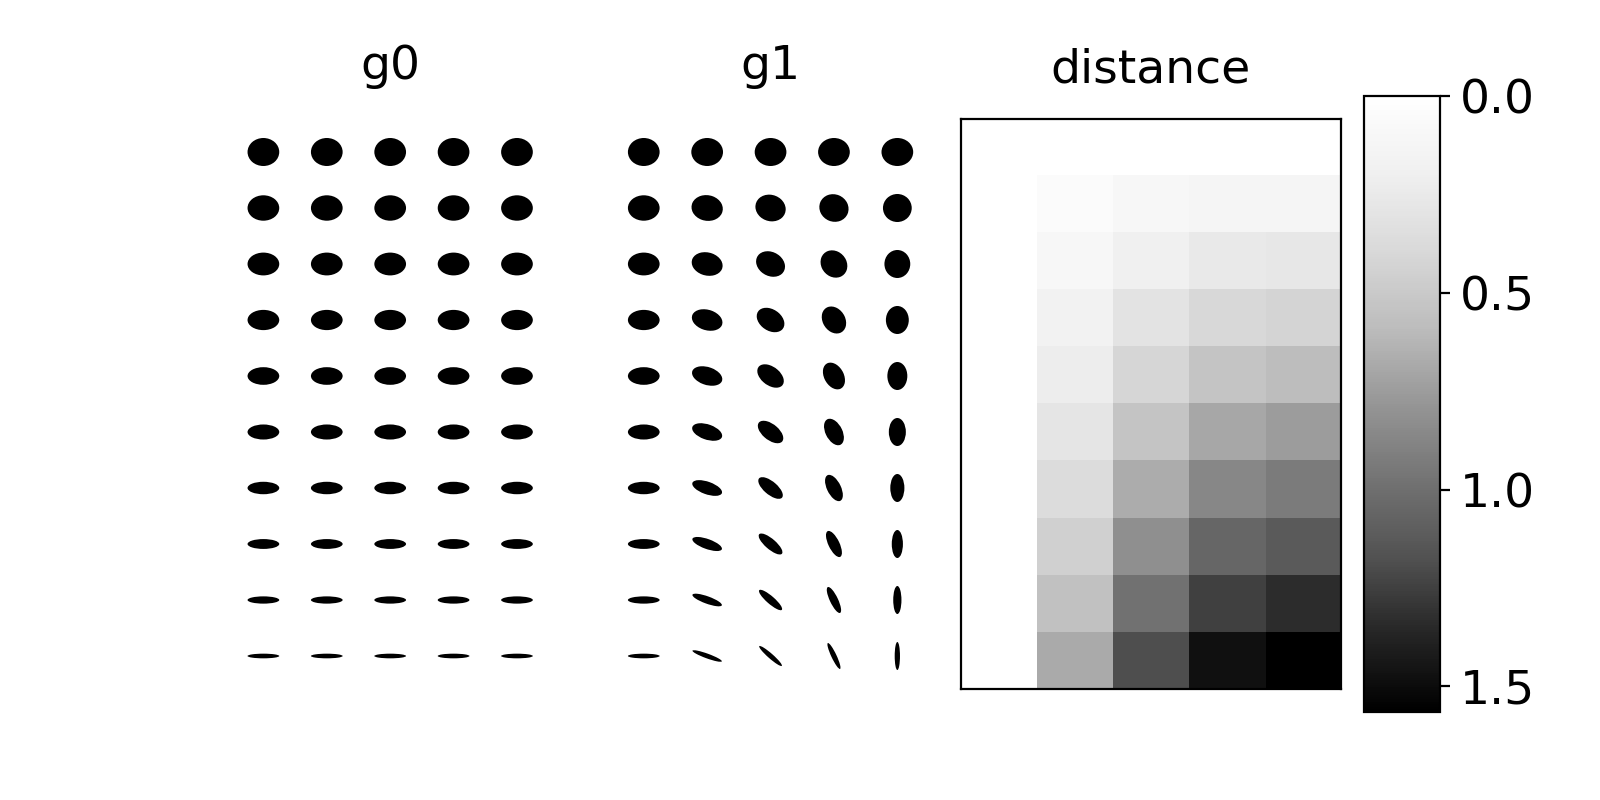

In [15]:
tens_fig=plt.figure(figsize=(8,4))
rows=1
cols=5 # 4th column is for spacing
grid = plt.GridSpec(rows, cols,wspace=0, width_ratios=(5,5,5,0.3,1))#, top=1, bottom=0, right=1, left=0, wspace=.01, hspace=0)

ax00 = plt.subplot(grid[0,0])
vis_tensors(np.transpose(rect_col1_tens,(2,1,0)), '',scale=0.5,opacity=1,ax=ax00)

if not show_axis_labels:
  ax00.set_xticks([])
  ax00.set_yticks([])
ax00.set_title('g0')
ax00.set_axis_off()
#ax00.xaxis.set_major_locator(plt.NullLocator())
#ax00.yaxis.set_major_locator(plt.NullLocator())
ax00.set_xlim(-1, rect_tens.shape[1])
ax00.set_ylim(-1, rect_tens.shape[0])
ax00.invert_yaxis()

ax01 = plt.subplot(grid[0,1])
vis_tensors(np.transpose(rect_tens,(2,1,0)), '', scale=0.5,opacity=1,ax=ax01)

if not show_axis_labels:
  ax01.set_xticks([])
  ax01.set_yticks([])
ax01.set_title('g1')
ax01.set_axis_off()
#ax01.xaxis.set_major_locator(plt.NullLocator())
#ax01.yaxis.set_major_locator(plt.NullLocator())
ax01.set_xlim(-1, euc_tens.shape[1])
ax01.set_ylim(-1, euc_tens.shape[0])
ax01.invert_yaxis()

ax02 = plt.subplot(grid[0,2])
#factor = 255/np.max(rect_euc_dist)

imobj = vis_2d(np.sqrt(rect_col1_dist), ax=ax02, cmap='Greys')
if not show_axis_labels:
  ax02.set_xticks([])
  ax02.set_yticks([])
    
ax02.set_title('distance', pad=13)
#ax02.margins(0,-0.5)
#ax02.set_axis_off()
#ax02.xaxis.set_major_locator(plt.NullLocator())
#ax02.yaxis.set_major_locator(plt.NullLocator())
#ax02.set_xlim(0.5, euc_tens.shape[1]-0.5)
#ax02.set_ylim(0.5, euc_tens.shape[0]-0.5)
#xm, ym = ax01.margins()
#ax02.margins(x=xm, y=ym)
#ax02.invert_yaxis()    
    
ax04 = plt.subplot(grid[0,4])
cbar = plt.colorbar(imobj, cax=ax04)
#cbar.set_label('Squared Distance')
cbar.ax.invert_yaxis()
plt.show()
if do_save:
  plt.gcf().savefig(fig_dir + 'rect_col1_dist.pdf', bbox_inches='tight', pad_inches=0.1, dpi=400, transparent=True)


In [16]:
rect_euc_geo = get_geo(torch.from_numpy(euc_tens_full), torch.from_numpy(rect_tens_full), 1.0/2.0, 7)
rect_col1_geo = get_geo(torch.from_numpy(rect_col1_full), torch.from_numpy(rect_tens_full), 1.0/2.0, 7)


<IPython.core.display.Javascript object>


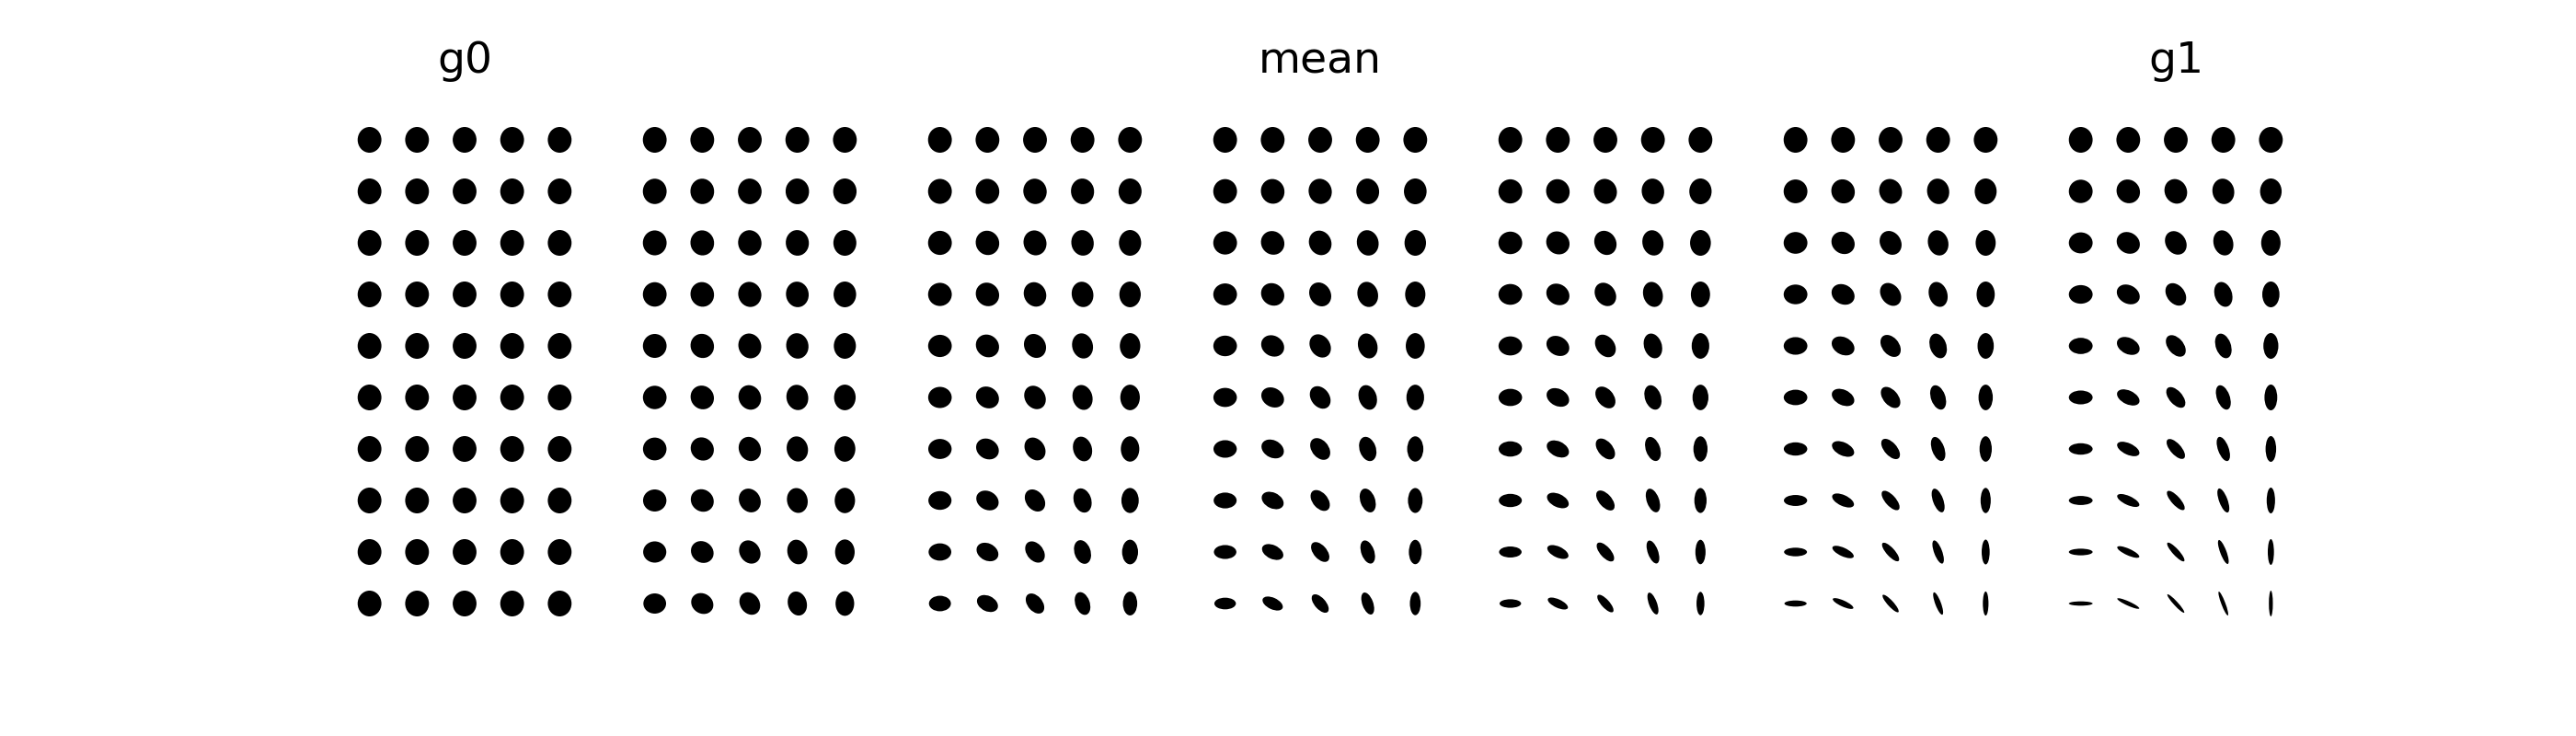

In [17]:
fig,axs=plot_geo(rect_euc_geo)
plt.show()
if do_save:
  plt.gcf().savefig(fig_dir + 'rect_euc_geo.pdf', bbox_inches='tight', pad_inches=0.1, dpi=400, transparent=True)


<IPython.core.display.Javascript object>


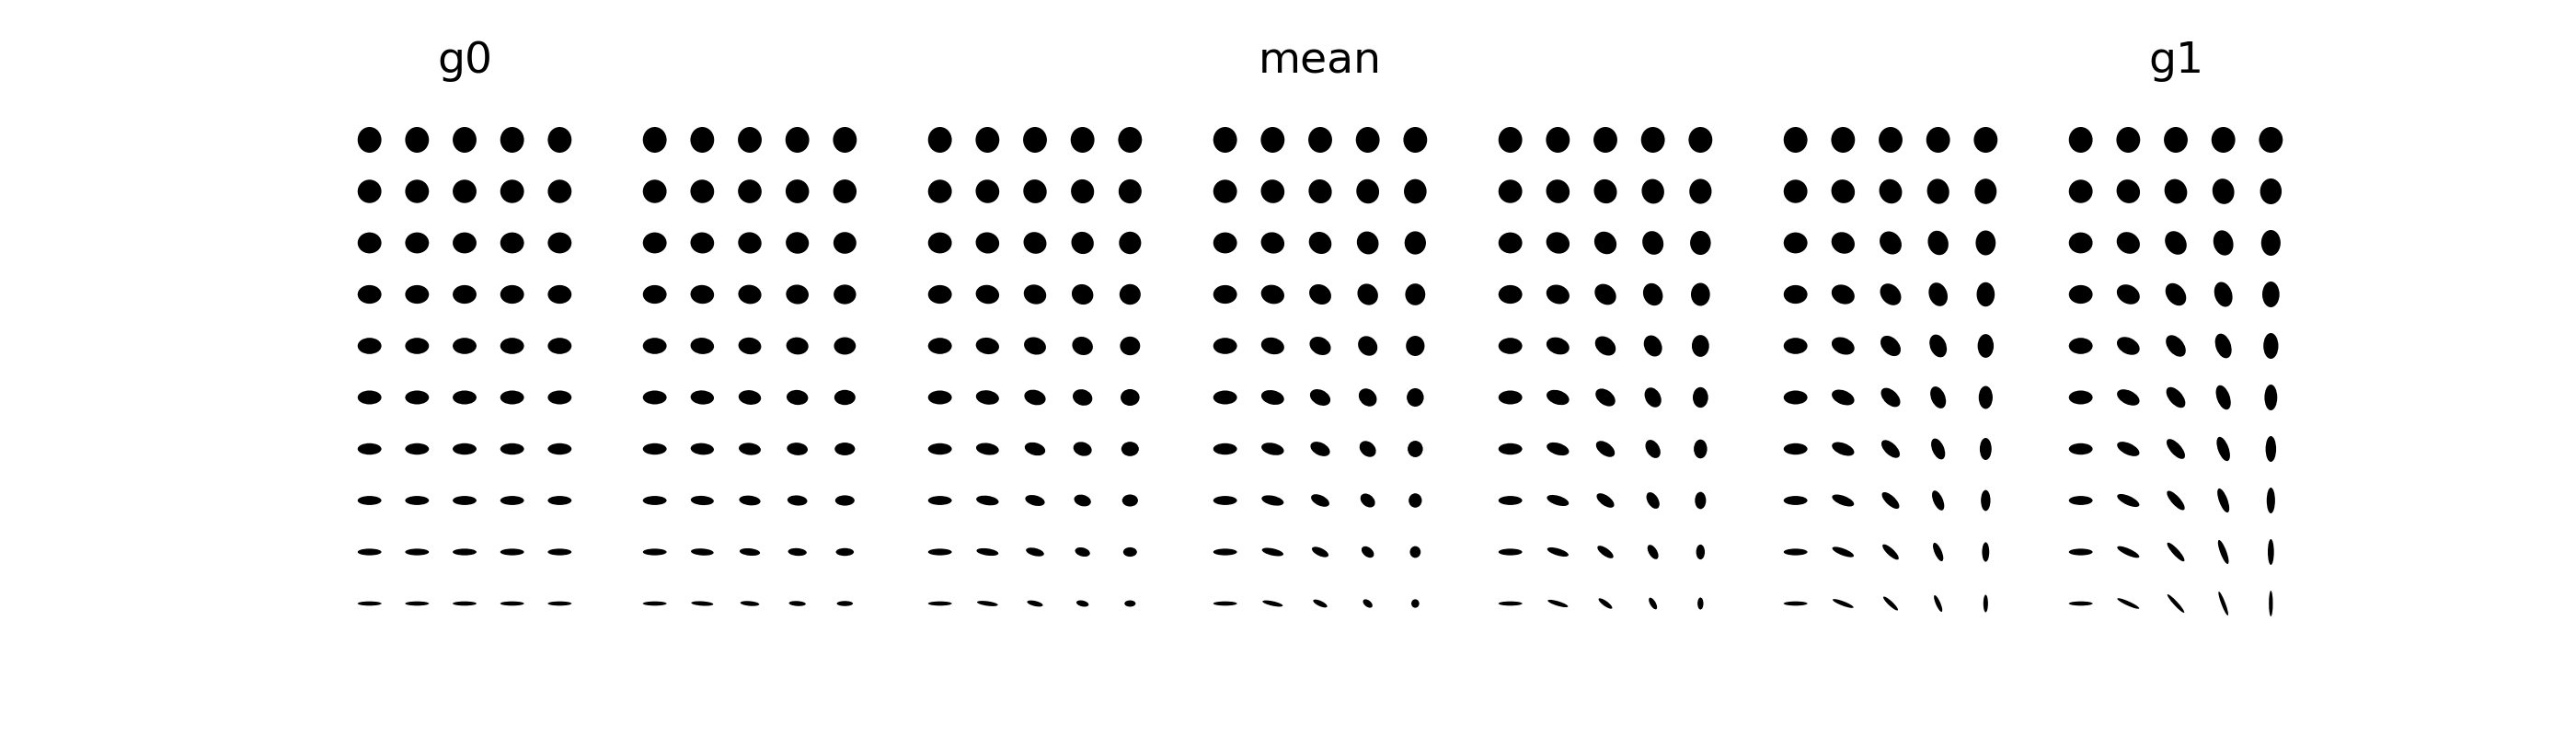

In [18]:
fig,axs=plot_geo(rect_col1_geo)
plt.show()
if do_save:
  plt.gcf().savefig(fig_dir + 'rect_col1_geo.pdf', bbox_inches='tight', pad_inches=0.1, dpi=400, transparent=True)


In [19]:
seeds=[]
for ii in range(1,11):
  seeds.append([3,ii])

rect_col1_geos = []
rect_euc_geos = []
mask = np.ones((rect_tens.shape[1]+2,rect_tens.shape[0]+2))
mask[0,:] = 0
mask[-1,:] = 0
mask[:,0] = 0
mask[:,-1] = 0
iso_tens_upper = np.ones((3))
iso_tens_upper[1] = 0
for gidx in range(rect_col1_geo.shape[0]):
  tens = rect_euc_geo[gidx]
  #tens = np.linalg.inv(rect_euc_geo[gidx])
  geo_euc_upper = np.zeros((rect_euc_geo.shape[1]+2, rect_euc_geo.shape[2]+2, 3))
  geo_euc_upper[1:-1,1:-1,0] = tens[:,:,0,0]
  geo_euc_upper[1:-1,1:-1,1] = tens[:,:,0,1]
  geo_euc_upper[1:-1,1:-1,2] = tens[:,:,1,1] 
  geo_euc_upper[0,:] = iso_tens_upper
  geo_euc_upper[-1,:] = iso_tens_upper
  geo_euc_upper[:,0] = iso_tens_upper
  geo_euc_upper[:,-1] = iso_tens_upper

  tens = rect_col1_geo[gidx]
  #tens = np.linalg.inv(rect_col1_geo[gidx])
  geo_col1_upper = np.zeros((rect_col1_geo.shape[1]+2, rect_col1_geo.shape[2]+2, 3))
  geo_col1_upper[1:-1,1:-1,0] = tens[:,:,0,0]
  geo_col1_upper[1:-1,1:-1,1] = tens[:,:,0,1]
  geo_col1_upper[1:-1,1:-1,2] = tens[:,:,1,1] 
  geo_col1_upper[0,:] = iso_tens_upper
  geo_col1_upper[-1,:] = iso_tens_upper
  geo_col1_upper[:,0] = iso_tens_upper
  geo_col1_upper[:,-1] = iso_tens_upper
  rect_euc_geos.append([])  
  rect_col1_geos.append([])
  for sidx in range(len(seeds)):
    geox, geoy = geo.geodesicpath(np.transpose(geo_euc_upper,(2,1,0)), \
                                  mask,\
                                  seeds[sidx], None, \
                                  0.1, iter_num=100, both_directions=True)
    rect_euc_geos[gidx].append((geox,geoy))
    geox, geoy = geo.geodesicpath(np.transpose(geo_col1_upper,(2,1,0)), \
                                  mask,\
                                  seeds[sidx], None, \
                                  0.1, iter_num=100, both_directions=True)
    rect_col1_geos[gidx].append((geox,geoy))

Finding geodesic path from [3, 1] with initial velocity [-1.0, -0.0]
Finding geodesic path from [3, 1] with initial velocity [1. 0.]
Finding geodesic path from [3, 1] with initial velocity [-1.0, -0.0]
Finding geodesic path from [3, 1] with initial velocity [1. 0.]
Finding geodesic path from [3, 2] with initial velocity [-1.0, -0.0]
Finding geodesic path from [3, 2] with initial velocity [1. 0.]
Finding geodesic path from [3, 2] with initial velocity [-1.0, -0.0]
Finding geodesic path from [3, 2] with initial velocity [1. 0.]
Finding geodesic path from [3, 3] with initial velocity [-1.0, -0.0]
Finding geodesic path from [3, 3] with initial velocity [1. 0.]
Finding geodesic path from [3, 3] with initial velocity [-1.0, -0.0]
Finding geodesic path from [3, 3] with initial velocity [1. 0.]
Finding geodesic path from [3, 4] with initial velocity [-1.0, -0.0]
Finding geodesic path from [3, 4] with initial velocity [1. 0.]
Finding geodesic path from [3, 4] with initial velocity [-1.0, -0.0]


Finding geodesic path from [3, 8] with initial velocity [0.7071067811865477, 0.7071067811865474]
Finding geodesic path from [3, 8] with initial velocity [-0.70710678 -0.70710678]
Finding geodesic path from [3, 8] with initial velocity [0.9750194703478207, 0.22211941032394047]
Finding geodesic path from [3, 8] with initial velocity [-0.97501947 -0.22211941]
Finding geodesic path from [3, 9] with initial velocity [0.7071067811865478, 0.7071067811865472]
Finding geodesic path from [3, 9] with initial velocity [-0.70710678 -0.70710678]
Finding geodesic path from [3, 9] with initial velocity [0.9762282225683938, 0.2167451440308513]
Finding geodesic path from [3, 9] with initial velocity [-0.97622822 -0.21674514]
Finding geodesic path from [3, 10] with initial velocity [-0.7071067811865475, -0.7071067811865475]
Finding geodesic path from [3, 10] with initial velocity [0.70710678 0.70710678]
Finding geodesic path from [3, 10] with initial velocity [0.9785328314052144, 0.20609099413146229]
Fin

Finding geodesic path from [3, 3] with initial velocity [0.7731645140337436, 0.6342055141978544]
Finding geodesic path from [3, 3] with initial velocity [-0.77316451 -0.63420551]
Finding geodesic path from [3, 4] with initial velocity [-0.7071067811865475, -0.7071067811865475]
Finding geodesic path from [3, 4] with initial velocity [0.70710678 0.70710678]
Finding geodesic path from [3, 4] with initial velocity [0.7728933498005363, 0.6345359484175077]
Finding geodesic path from [3, 4] with initial velocity [-0.77289335 -0.63453595]
Finding geodesic path from [3, 5] with initial velocity [-0.7071067811865475, -0.7071067811865475]
Finding geodesic path from [3, 5] with initial velocity [0.70710678 0.70710678]
Finding geodesic path from [3, 5] with initial velocity [0.7724342266524089, 0.6350947689092511]
Finding geodesic path from [3, 5] with initial velocity [-0.77243423 -0.63509477]
Finding geodesic path from [3, 6] with initial velocity [-0.7071067811865475, -0.7071067811865475]
Findin

<IPython.core.display.Javascript object>


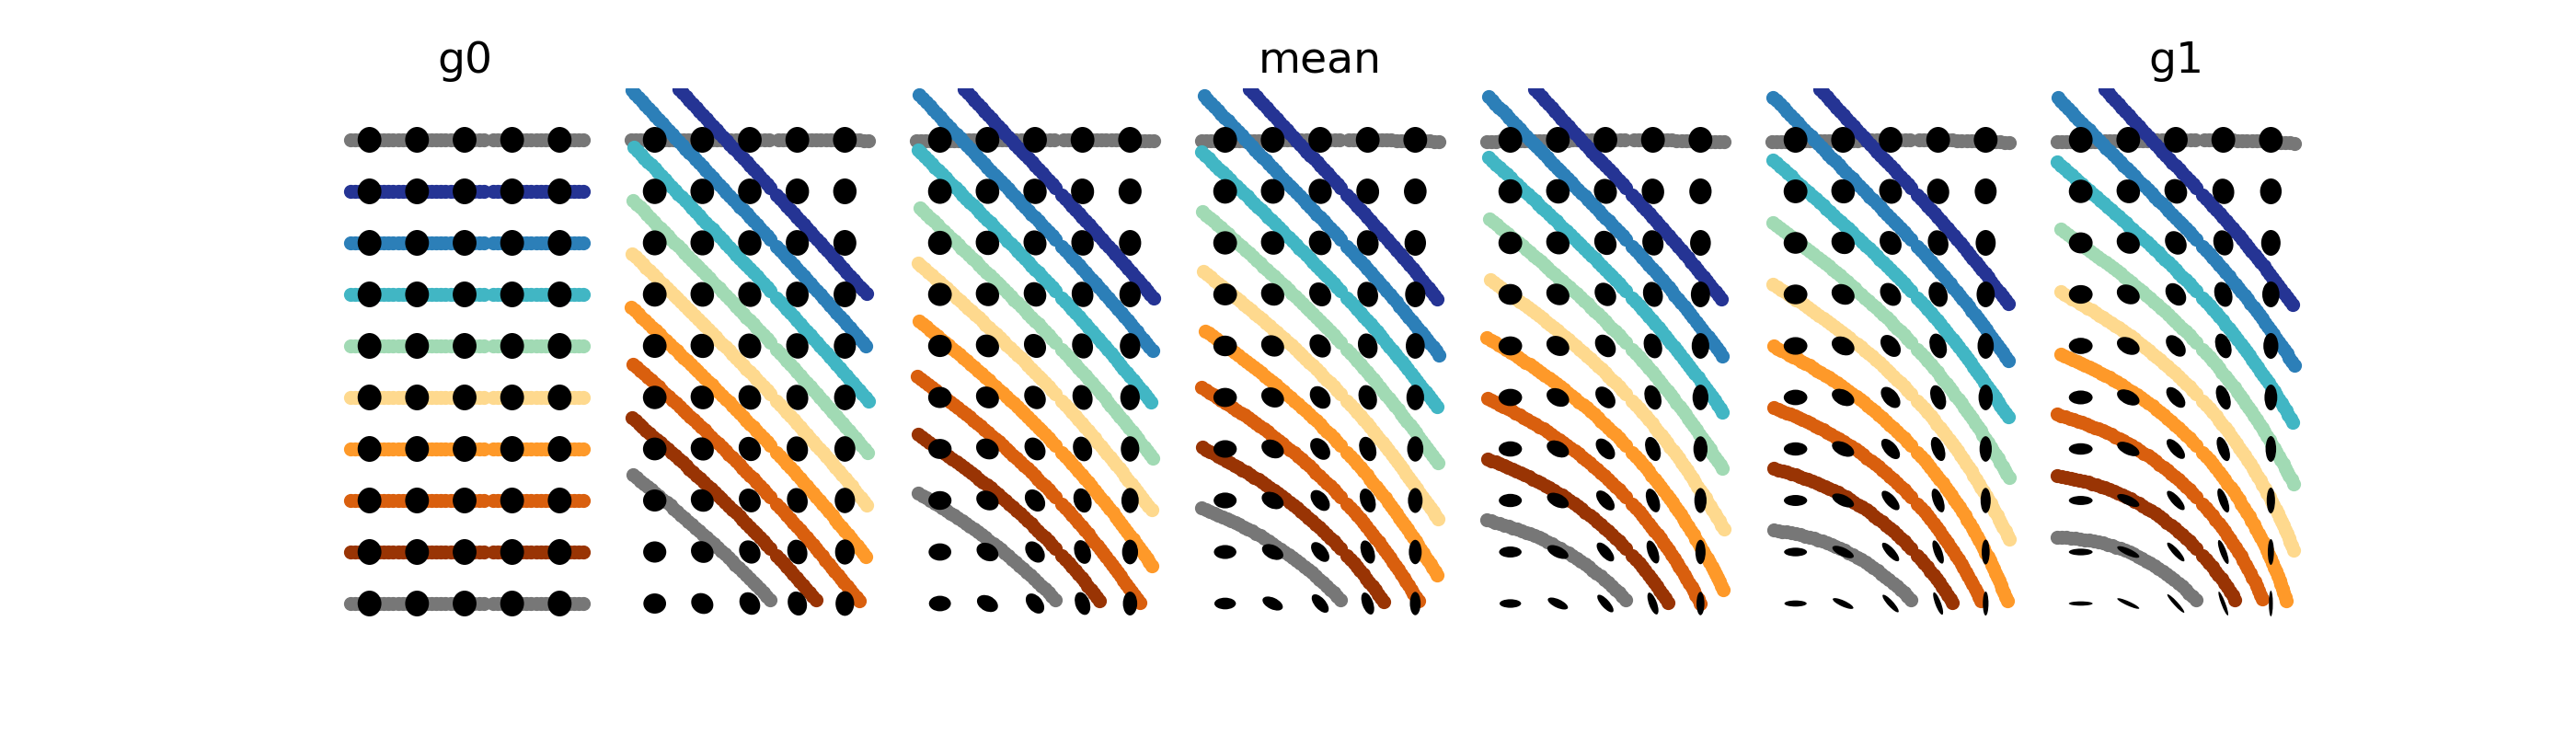

In [20]:
fig,axs=plot_geo(rect_euc_geo)
for gidx in range(rect_euc_geo.shape[0]):
  for sidx in range(len(seeds)):
    curgeo = rect_euc_geos[gidx][sidx]
    vis_path(curgeo[0]-0.5,curgeo[1]-1,fig,do_legend=False,color=interp_colors[sidx % len(interp_colors)],ax=axs[gidx])

plt.show()    
if do_save:
  plt.gcf().savefig(fig_dir + 'rect_euc_paths.pdf', bbox_inches='tight', pad_inches=0.1, dpi=400, transparent=True)

    

<IPython.core.display.Javascript object>


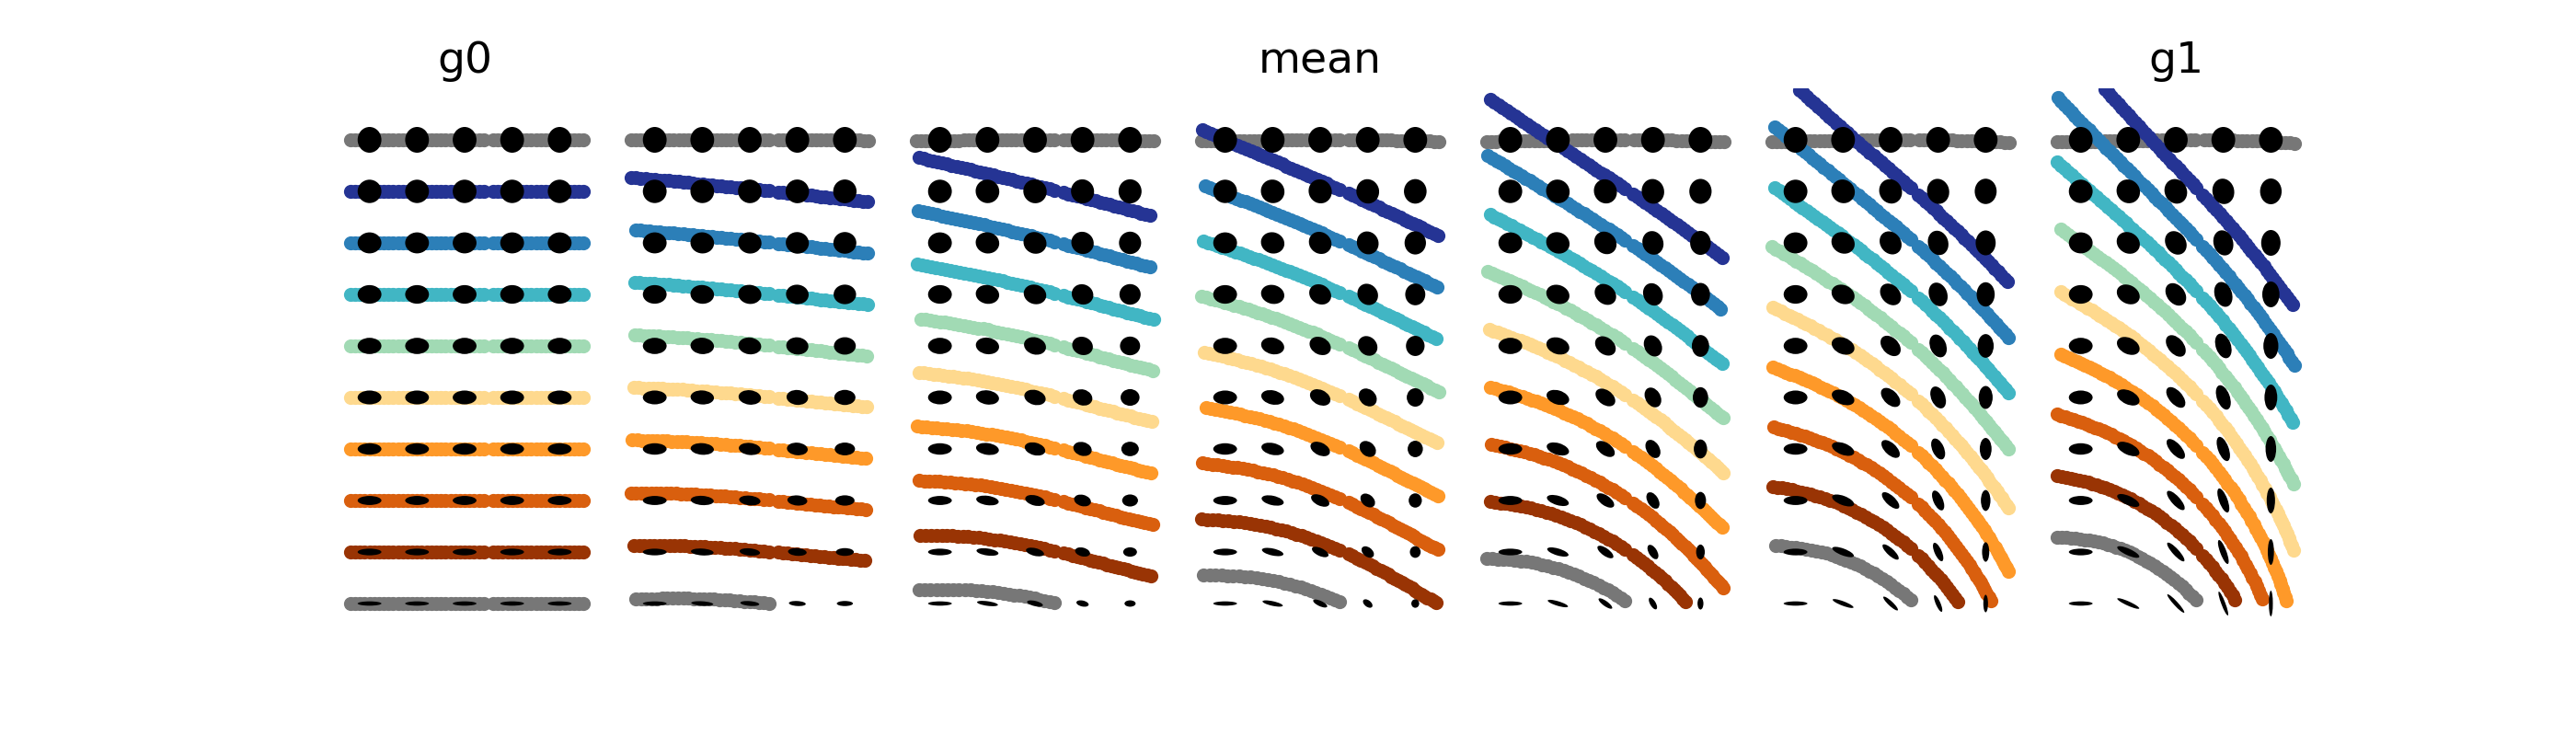

In [21]:
fig,axs=plot_geo(rect_col1_geo)
for gidx in range(rect_col1_geo.shape[0]):
  for sidx in range(len(seeds)):
    curgeo = rect_col1_geos[gidx][sidx]
    vis_path(curgeo[0]-0.5,curgeo[1]-1,fig,do_legend=False,color=interp_colors[sidx % len(interp_colors)],ax=axs[gidx])

plt.show()
if do_save:
  plt.gcf().savefig(fig_dir + 'rect_col1_paths.pdf', bbox_inches='tight', pad_inches=0.1, dpi=400, transparent=True)

 